#   Задача Навигатор
## 
    - Принимает матрицу местности, где 1 - проходимый участок, 0 - непроходимый участок, начальные координаты курьера, координаты доставок
    - Строит матрицу стоимости пути до каждой клетки, от каждого заказа и от курьера
    - Вычисляет минимальную стоимость между всеми контрольными точками
    - Ищет оптимальный порядок доставок
    - Строит оптимальный путь в оптимальном порядке

In [274]:
#Принимаем данные

import pandas as pd
import numpy as np
import random


df = pd.read_csv('city_map.csv', names=list(range(0, 100, 1)))
city_map_list = df.values.tolist()


orders_location = [(27, 80), (26, 75), (43, 52), (42, 76)] 


orders_location = list(set((random.randrange(0,100), random.randrange(0,100))for i in range(10)))

courier_location = (random.randrange(0,100), random.randrange(0,100))
while courier_location in orders_location or city_map_list[courier_location[1]][courier_location[0]] == 0:
    courier_location = (random.randrange(0,100), random.randrange(0,100))


orders_location, courier_location

([(97, 56),
  (28, 81),
  (75, 90),
  (58, 17),
  (96, 26),
  (72, 58),
  (29, 12),
  (34, 12),
  (89, 53),
  (27, 25)],
 (10, 74))

In [275]:
city_map_list = np.array(city_map_list)

In [276]:
# Строим матрицы для каждого заказа, с запасом для удобства
orders_value_map = []
for i in range(len(orders_location)):
    temp_map = np.zeros((city_map_list.shape[0]+2, city_map_list.shape[1]+2))
    temp_map[1:-1,1:-1] = city_map_list[:,:]
    orders_value_map.append(temp_map)

# Выкалываем собственные координаты
    
for i in range(len(orders_value_map)):
    orders_value_map[i][orders_location[i][1]+1][orders_location[i][0]+1] = -1
# Тоже самое для курьера
courier_value_map = np.zeros((city_map_list.shape[0]+2, city_map_list.shape[1]+2))
courier_value_map[1:-1,1:-1] = city_map_list[:,:]
courier_value_map[courier_location[1]+1][courier_location[0]+1] = -1


In [277]:
# Функция вычисления стоимости, работает с условием того, что до любой проходимой точки можно добраться

def build_values(map):
    while 1 in map:
        for i in range(1,map.shape[0]-1):
            for j in range(1,map.shape[1]-1):
                if map[i,j] < 1:
                    continue
                
                adjacent = list(filter(lambda x: x != 0 and x != 1,[map[i,j+1], map[i,j-1], map[i+1,j], map[i-1,j]]))
                if adjacent:
                    map[i,j] = min(adjacent) +10

In [278]:
# Строим для каждой контрольной точки
for i in orders_value_map:
    build_values(i)

build_values(courier_value_map)

In [279]:
# Поиск оптимального порядка доставок
def find_optimal_order(courier_value_map,orders_location,orders_value_map):
    courier_order_cost = []
    for i in orders_location:
        courier_order_cost.append(courier_value_map[i[1]+1,i[0]+1])
    orders_to_orders_cost = np.array([np.zeros(len(orders_location)) for _ in range(len(orders_location))])
    for i in range(len(orders_location)-1):
        for j in range(i+1,len(orders_location)):
            orders_to_orders_cost[i,j] = orders_value_map[i][orders_location[j][1]+1,orders_location[j][0]+1]
            orders_to_orders_cost[j,i] = orders_to_orders_cost[i,j]
            
    min_full_cost = max(courier_order_cost) + np.sum(orders_to_orders_cost)
    cheapest_path = []
    
    count_iterations = 0
    def calculate_minimum_cost_recursive(orders_to_orders_cost,path,summary):
        nonlocal count_iterations
        count_iterations+=1
        nonlocal min_full_cost
        nonlocal cheapest_path
        if len(path) == len(orders_location):
            if summary < min_full_cost:
                min_full_cost = summary
                cheapest_path = path
            return
        for i in range(len(orders_to_orders_cost)):
            if i in path:
                continue
            calculate_minimum_cost_recursive(orders_to_orders_cost, path+[i],summary+orders_to_orders_cost[path[-1],i])
    
    for i in range(len(courier_order_cost)):
        calculate_minimum_cost_recursive(orders_to_orders_cost, [i], courier_order_cost[i])
    print(count_iterations)
                
        
        
        
    return cheapest_path

In [280]:
optimal_order = find_optimal_order(courier_value_map,orders_location,orders_value_map)

9864100


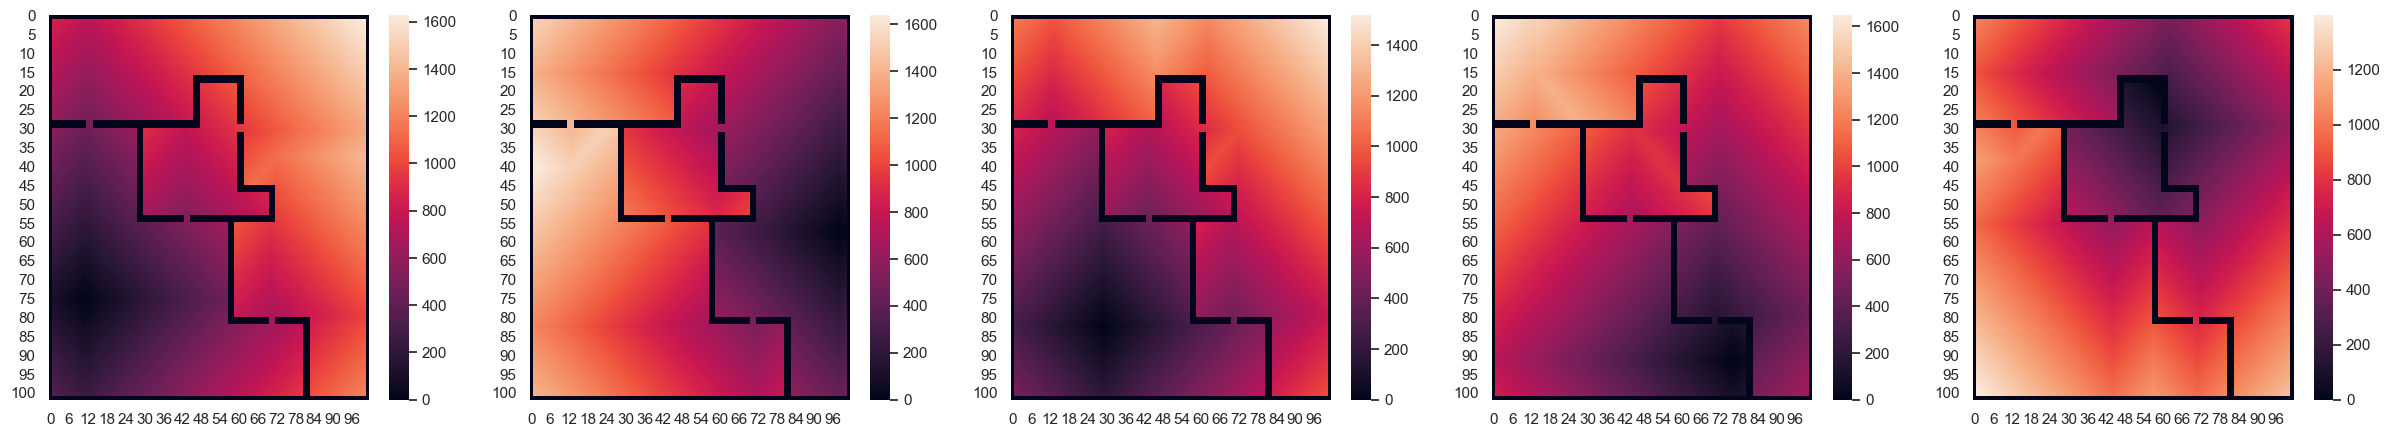

In [281]:
# Доступность схематично
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=[30,5])
plt.subplot(151)
sns.heatmap(courier_value_map)
for i in range(4):
    pos = 152+i
    plt.subplot(pos)
    sns.heatmap(orders_value_map[i])

In [282]:
orders_location[optimal_order[1]]

(75, 90)

In [283]:
# Построение быстрейшего пути по оптимальному маршруту
def build_root(optimal_order, courier_location, courier_value_map, orders_location, orders_value_map):
    route = []
    for i in range(-1,len(optimal_order)-1):
        temp = []
        if i == -1:
            curr = orders_location[optimal_order[0]]
            while(curr != courier_location):
                adjacent = list(filter( lambda x : courier_value_map[x[1]+1,x[0]+1] != 0, [(curr[0],curr[1]+1), (curr[0]+1,curr[1]), (curr[0],curr[1]-1), (curr[0]-1,curr[1])]))
                curr = min(adjacent, key = (lambda x: courier_value_map[x[1]+1,x[0]+1]))
                temp.append(curr)
            route.extend(temp[::-1])
        else:
            curr = orders_location[optimal_order[i+1]]
            while(curr != orders_location[optimal_order[i]]):
                adjacent = list(filter( lambda x : orders_value_map[optimal_order[i]][x[1]+1,x[0]+1] != 0, [(curr[0],curr[1]+1), (curr[0]+1,curr[1]), (curr[0],curr[1]-1), (curr[0]-1,curr[1])]))
                curr = min(adjacent, key = (lambda x: orders_value_map[optimal_order[i]][x[1]+1,x[0]+1]))
                temp.append(curr)
            route.extend(temp[::-1])
    route.append(orders_location[optimal_order[-1]])
    return route
            
                

In [284]:

route = build_root(optimal_order, courier_location, courier_value_map, orders_location, orders_value_map)

<Axes: >

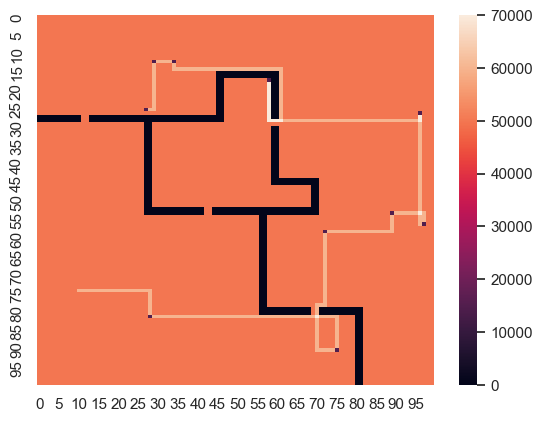

In [287]:
# Визуализация найденого пути
route_map = city_map_list.copy()
route_map*=50000
for i in route:
    route_map[i[1],i[0]] += 10000

for i in orders_location:
    route_map[i[1],i[0]] = 15000
sns.heatmap(route_map)

In [286]:

len(route)

313